In [62]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
import neurodsp as ndsp
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
from scv_funcs import lfpca, utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

from scipy import io
import os
import sys
import h5py
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1.0, 100.0)

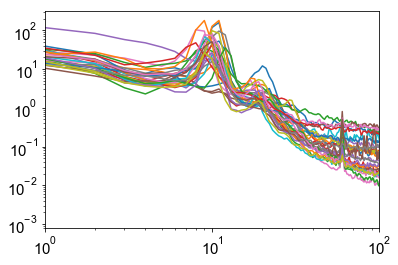

In [3]:
# get all the subject file names in a list
datafolder = '/Users/rdgao/Documents/data/EEGData_Tom/'
subj_list = [i for i in range(1000,1015)]
for i in range(2000,2014):
    subj_list.append(i)

    
keys = ['oz_rest_data','oz_trial_data']
key=keys[0]

# cycle through
for subj in subj_list:
    data = io.loadmat(datafolder+ str(subj) + '.mat', squeeze_me=True)
    x = data[key]
    fs = 500.
    freq, psd = ndsp.spectral.psd(x, fs, nperseg=int(fs))
    plt.loglog(freq, psd)
    
plt.xlim([1.,100.])

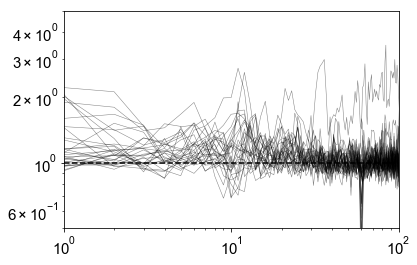

In [5]:
# cycle through
keys = ['oz_rest_data','oz_trial_data']
key=keys[0]

for subj in subj_list:
    data = io.loadmat(datafolder+ str(subj) + '.mat', squeeze_me=True)
    x = data[key]
    #print(len(x))
    fs = 500.
    freq, scv = ndsp.spectral.scv(x, fs, nperseg=int(fs), outlierpct=2.)
    plt.loglog(freq, scv, 'k', lw=0.5, alpha=0.5)
    
plt.xlim([1.,100.])
plt.ylim([0.5,5])
plt.plot([1, 100], [1, 1], 'k--')

### Computing LFPCA

In [77]:
lfpca_rest = []
lfpca_task = []
fs = 500.
params = {'nperseg':int(fs), 'noverlap':int(fs/4), 'spg_outlierpct':2, 'max_freq':200}

for subj in subj_list:
    data = io.loadmat(datafolder+ str(subj) + '.mat', squeeze_me=True)
    x = data[keys[0]].reshape(1,-1)
    lf = lfpca.LFPCA(analysis_params=params)
    lf.populate_ts_data(x,fs)
    lf.compute_all_spectral()
    lf.compute_KS_expfit()
    lfpca_rest.append(lf)
        
    x = data[keys[1]].reshape(1,-1)
    lf = lfpca.LFPCA(analysis_params=params)
    lf.populate_ts_data(x,fs)
    lf.compute_all_spectral()
    lf.compute_KS_expfit()
    lfpca_task.append(lf)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


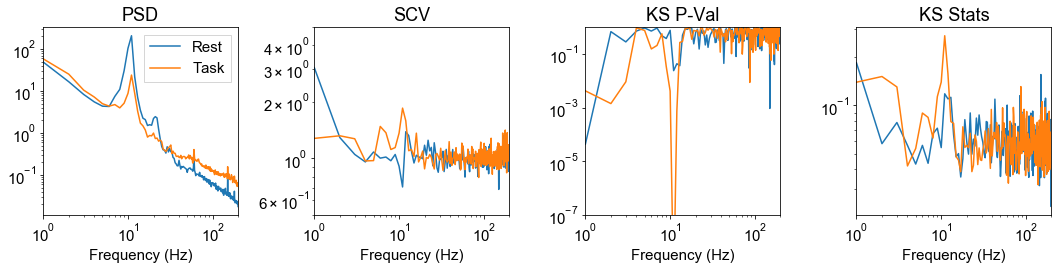

In [81]:
subj_plot=11
plt.figure(figsize=(15,4))
lfpca_rest[subj_plot].plot_spectral(plot_mean=False,plot_color=CKEYS[0])
lfpca_task[subj_plot].plot_spectral(plot_mean=False,plot_color=CKEYS[1])
plt.subplot(1,4,1)
plt.legend(['Rest', 'Task'], fancybox=False)
plt.tight_layout()

In [19]:
scv_rest = []
scv_task = []
fs = 500.
nperseg = int(fs/2)

for subj in subj_list:
    data = io.loadmat(datafolder+ str(subj) + '.mat', squeeze_me=True)
    x = data[keys[0]]
    freq, scv = spectral.scv(x, fs, nperseg=int(fs/2), outlierpct=2.)
    scv_rest.append(np.expand_dims(scv,1))
    
    x = data[keys[1]]
    freq, scv = spectral.scv(x, fs, nperseg=int(fs/2), outlierpct=2.)
    scv_task.append(np.expand_dims(scv,1))

scv_rest=np.log10(np.concatenate(scv_rest,1))
scv_task=np.log10(np.concatenate(scv_task,1))

(-0.060105499, 0.75677357914056786)

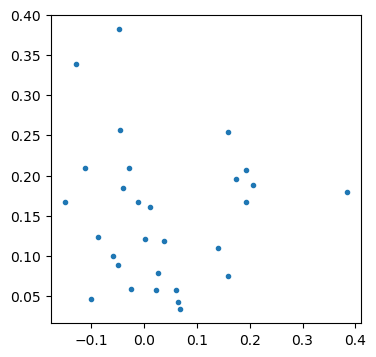

In [24]:
plt.plot(scv_rest[np.where(freq==10)[0][0],:],scv_task[np.where(freq==10)[0][0],:],'.')
sp.stats.pearsonr(scv_rest[np.where(freq==10)[0][0],:],scv_task[np.where(freq==10)[0][0],:])

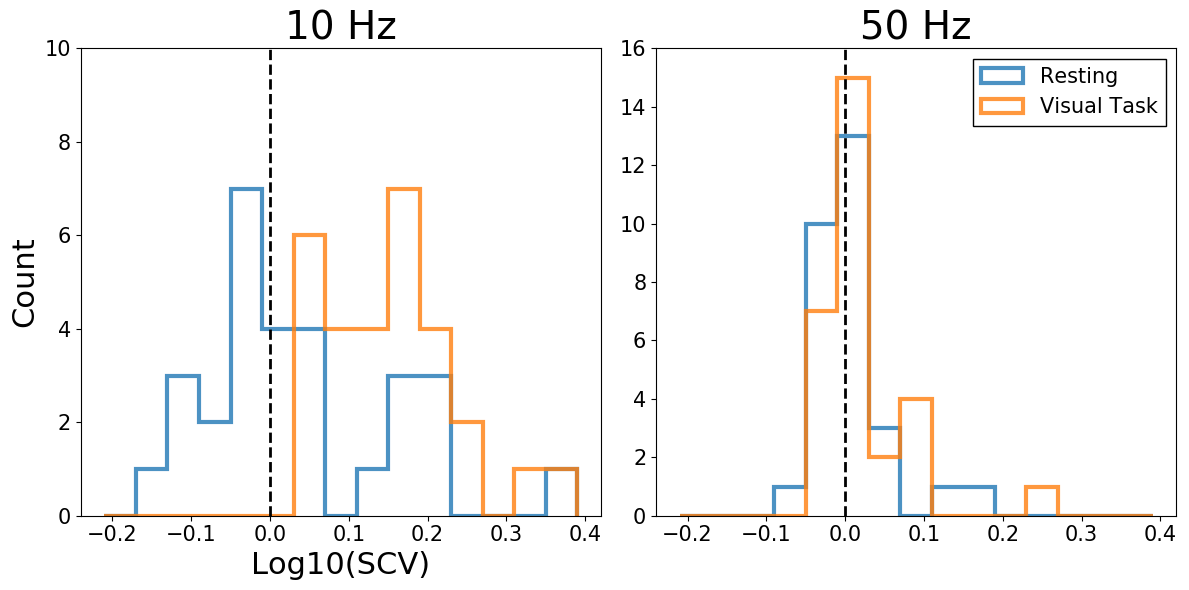

In [20]:
bins = np.arange(-.21,.41,0.04)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(scv_rest[np.where(freq==10)[0][0],:], bins,lw=3, histtype='step', alpha=0.8)
plt.hist(scv_task[np.where(freq==10)[0][0],:],bins,lw=3, histtype='step', alpha=0.8)
plt.plot([0,0], [0,10], 'k--', lw=2)
plt.ylim([0, 10])
plt.xlabel('Log10(SCV)', fontsize=22)
plt.ylabel('Count', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(('10 Hz'), fontsize=28)

plt.subplot(1,2,2)
plt.hist(scv_rest[np.where(freq==50)[0][0],:],bins,lw=3, histtype='step', alpha=0.8)
plt.hist(scv_task[np.where(freq==50)[0][0],:],bins,lw=3, histtype='step', alpha=0.8)
plt.ylim([0, 16])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(('Resting', 'Visual Task'),fontsize=15)
plt.plot([0,0], [0,16], 'k--', lw=2)
plt.title(('50 Hz'), fontsize=28)

plt.tight_layout()

In [11]:
# testing the different distributions
# test the logged values against 0
print('10 Hz')
print(sp.stats.wilcoxon(scv_rest[np.where(freq==10)[0][0],:])) # rest
print(sp.stats.wilcoxon(scv_task[np.where(freq==10)[0][0],:])) # task
print(sp.stats.wilcoxon(scv_rest[np.where(freq==10)[0][0],:],scv_task[np.where(freq==10)[0][0],:])) #rest task diff

print('50 Hz')
print(sp.stats.wilcoxon(scv_rest[np.where(freq==50)[0][0],:])) # rest
print(sp.stats.wilcoxon(scv_task[np.where(freq==50)[0][0],:])) # task
print(sp.stats.wilcoxon(scv_rest[np.where(freq==50)[0][0],:],scv_task[np.where(freq==10)[0][0],:])) #rest task diff

10 Hz
WilcoxonResult(statistic=166.0, pvalue=0.26545303243391527)
WilcoxonResult(statistic=0.0, pvalue=2.5630832507250074e-06)
WilcoxonResult(statistic=64.0, pvalue=0.00090288234342382858)
50 Hz
WilcoxonResult(statistic=207.0, pvalue=0.82038982987425801)
WilcoxonResult(statistic=124.0, pvalue=0.043200189792443153)
WilcoxonResult(statistic=0.0, pvalue=2.5630832507250074e-06)


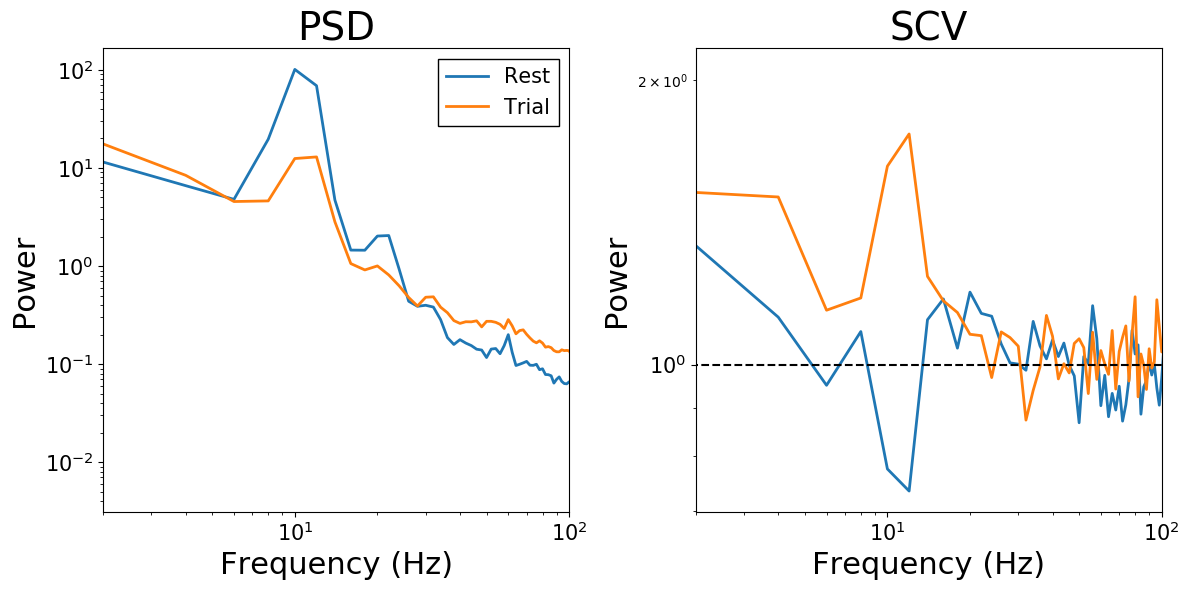

In [90]:
# example subject
subj = subj_list[11]
data = io.loadmat(datafolder+ str(subj) + '.mat', squeeze_me=True)
fs = 500.
OL=2.
nperseg=int(fs/2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
freq, psd = spectral.psd(data['oz_rest_data'], fs, nperseg=nperseg)
plt.loglog(freq, psd, lw=2)
freq, psd = spectral.psd(data['oz_trial_data'], fs, nperseg=nperseg)
plt.loglog(freq, psd, lw=2)
plt.xlim([2.,100.])
plt.legend(('Rest','Trial'), fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Frequency (Hz)',fontsize=22)
plt.ylabel('Power',fontsize=22)
plt.title('PSD',fontsize=28)


plt.subplot(1,2,2)
freq, scv = spectral.scv(data['oz_rest_data'], fs, nperseg=nperseg, outlierpct=OL)
plt.loglog(freq,scv, lw=2);
freq, scv = spectral.scv(data['oz_trial_data'], fs, nperseg=nperseg, outlierpct=OL)
plt.loglog(freq,scv, lw=2);
plt.xlim([2.,100.])
plt.plot([1, 100], [1, 1], 'k--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Frequency (Hz)',fontsize=22)
plt.ylabel('Power',fontsize=22)
plt.title('SCV',fontsize=28)
plt.tight_layout()

# plt.plot([0,0], [0,150], 'k--', lw=2)
# plt.ylim([0, 140])
# plt.xlabel('Log10(SCV)', fontsize=22)
# plt.ylabel('Count', fontsize=22)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.title('Rat SCV All Channels', fontsize=28)

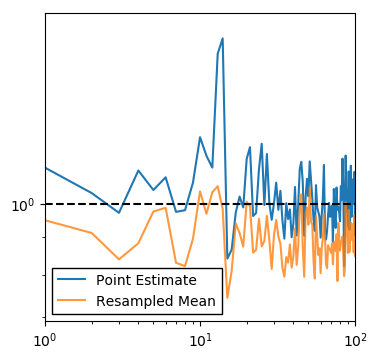

In [5]:
subj = subj_list[0]
data = io.loadmat(datafolder+ str(subj) + '.mat', squeeze_me=True)
x = data['oz_rest_data']
#x = data['oz_trial_data']
freq, scv = spectral.scv(x, fs, nperseg=int(fs), outlierpct=2.)
freq, T, scv_rs = spectral.scv_rs(x, fs, nperseg=int(fs), method='bootstrap', rs_params=(10,100))
plt.loglog(freq,scv);
plt.loglog(freq,np.mean(scv_rs,1), alpha=0.8);
plt.legend(('Point Estimate','Resampled Mean'))
plt.xlim([1.,100.])
plt.plot([1, 100], [1, 1], 'k--')